<a href="https://colab.research.google.com/github/letsgoahasanur/LRScheduler/blob/main/lrscheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))  # GPU name (e.g., Tesla T4)

True
Tesla T4


In [4]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip


Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [5]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Transforms (resize, normalize, augment)
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.480, 0.448, 0.398], [0.277, 0.269, 0.282])
])

train_dataset = ImageFolder('tiny-imagenet-200/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_dataset = ImageFolder('tiny-imagenet-200/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)


In [6]:
import torch.nn as nn
import torchvision.models as models

model = models.mobilenet_v2(weights=None)  # start from scratch
model.classifier[1] = nn.Linear(model.last_channel, 200)  # Tiny ImageNet has 200 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Schedulers
step_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=20)
plateau_scheduler = ReduceLROnPlateau(optimizer, 'min')


In [14]:
train_losses = []
learning_rates = []
val_accuracies = []

for epoch in range(20):  # you can increase epochs later
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        lr = optimizer.param_groups[0]['lr']
        learning_rates.append(lr)
        train_losses.append(loss.item())


    # Example for StepLR or Cosine scheduler
    step_scheduler.step()
    #cosine_scheduler.step()

    # ReduceLROnPlateau example
    # plateau_scheduler.step(running_loss / len(train_loader))

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 2.3121
Epoch 2, Loss: 2.3094
Epoch 3, Loss: 2.3151
Epoch 4, Loss: 2.3096
Epoch 5, Loss: 2.3090
Epoch 6, Loss: 2.3106
Epoch 7, Loss: 2.3090
Epoch 8, Loss: 2.3102
Epoch 9, Loss: 2.3156
Epoch 10, Loss: 2.3102
Epoch 11, Loss: 2.3084
Epoch 12, Loss: 2.3094
Epoch 13, Loss: 2.3077
Epoch 14, Loss: 2.3090
Epoch 15, Loss: 2.3151
Epoch 16, Loss: 2.3132
Epoch 17, Loss: 2.3050
Epoch 18, Loss: 2.3087
Epoch 19, Loss: 2.3088
Epoch 20, Loss: 2.3120


In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:   # make sure you created val_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
val_accuracies.append(accuracy)

print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Val Acc: {accuracy:.2f}%")


Epoch 20, Loss: 2.3120, Val Acc: 0.59%


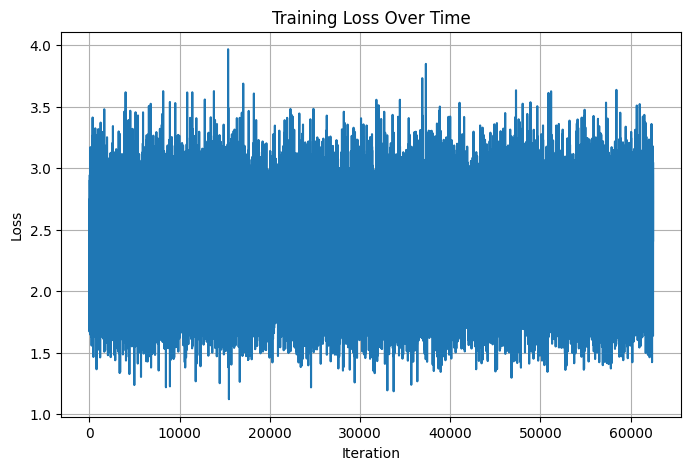

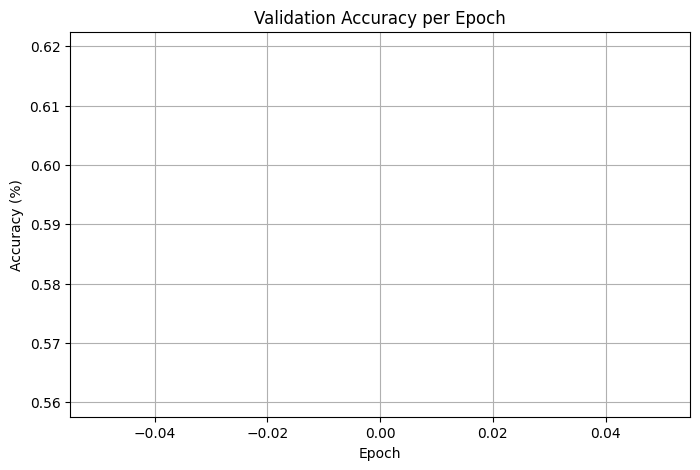

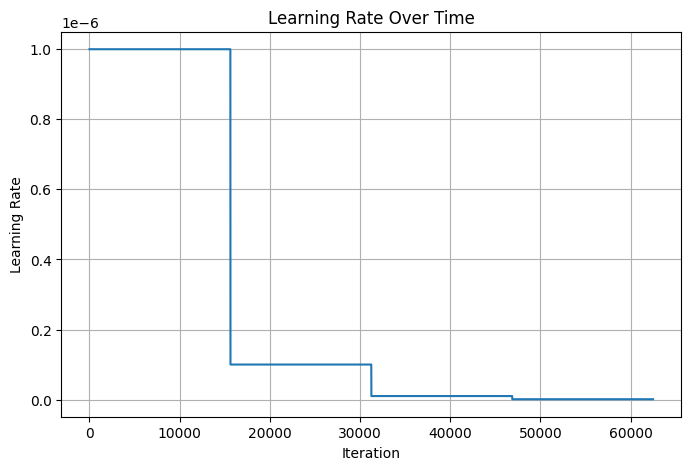

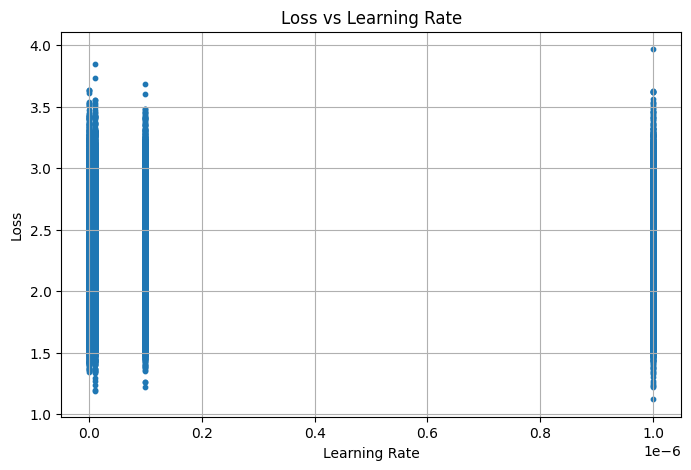

In [16]:
import matplotlib.pyplot as plt

# ---- Plot 1: Training Loss vs Epoch ----
plt.figure(figsize=(8,5))
plt.plot(train_losses)
plt.title("Training Loss Over Time")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ---- Plot 2: Validation Accuracy vs Epoch ----
plt.figure(figsize=(8,5))
plt.plot(val_accuracies)
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

# ---- Plot 3: Learning Rate vs Epoch ----
plt.figure(figsize=(8,5))
plt.plot(learning_rates)
plt.title("Learning Rate Over Time")
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()

# ---- Plot 4: Loss vs Learning Rate ----
plt.figure(figsize=(8,5))
plt.scatter(learning_rates, train_losses, s=10)
plt.title("Loss vs Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

